In [1]:
import pandas as pd
import numpy as np
import random
from functools import partial

%matplotlib inline
from matplotlib import pyplot

## Experiment 1: static vote counting

In [53]:
def count_votes(sampling_dist,nb_iter,condition):
    def check_quality(idx_ans):
        if condition.iloc[idx_ans]>random.random() :
            return idx_ans + 1
        return 0
                
    counts_cond = pd.concat([sampling_dist]*nb_iter,axis=1).apply(
                        lambda col: check_quality(col[col>random.random()].index[0]))
    return counts_cond[counts_cond>0].values

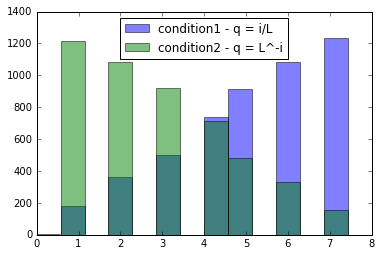

In [54]:

nb_iter = 10000
nb_ans = 8
pbias = pd.Series([1 - i/nb_ans for i in range(1,nb_ans+1)])
pbias = (pbias/pbias.sum()).cumsum()
count_experiment = partial(count_votes,pbias,nb_iter)

q1 = pd.Series([float(i)/nb_ans for i in range(1,nb_ans+1)])
q2 = pd.Series([1 - float(i)/nb_ans for i in range(1,nb_ans+1)])
#q2 = pd.Series([(nb_ans**-i) for i in range(1,nb_ans+1)])


bins = np.linspace(0, nb_ans, int((nb_ans-1)/0.5)+1)        
pyplot.hist(count_experiment(q1), bins, alpha=0.5,label='condition1 - q = i/L')
pyplot.hist(count_experiment(q2), bins, alpha=0.5,label='condition2 - q = L^-i')
pyplot.legend(loc='best')
pyplot.show()

## Experiment 2: do answers find a stable position?

In [2]:
from scipy.stats import beta

In [3]:
def voting_pq(pbias,tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    while True:
        sample_idx = pbias[pbias>random.random()].index[0]
        if q_votes['q'].iloc[sample_idx]>random.random():
            q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
            q_votes = q_votes.sort_values(by=['votes'],ascending=False)
            q_votes.index = range(q_votes.shape[0])
            yield np.absolute(q_votes['ans'].values-tgt_order).mean()

In [4]:
import sys
def get_drank(votes):
    if 'DRank' in votes.columns:
        votes = votes.drop('DRank',1)
    q_votes_rs = votes.sort_values(by='q').reset_index(drop=False)
    q_votes_rs.loc[:,'DRank'] = q_votes_rs['index'].values - q_votes_rs.index.values
    q_votes_rs.loc[:,'DRank'] = np.exp(-q_votes_rs['DRank'])
    q_votes_rs.loc[:,'DRank'] = q_votes_rs['DRank']/q_votes_rs['DRank'].sum()
    q_votes = pd.merge(votes,q_votes_rs[['ans','DRank']],how='inner',on='ans')
    q_votes.loc[:,'DRank'] = q_votes['DRank'].cumsum()
    return q_votes
    
def voting_ex1(pbias,tgt_order,alpha,beta,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],
                         pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    q_votes = get_drank(q_votes)
    while True:
        if (q_votes['DRank']==0).all():
            sample_idx = pbias[pbias>random.random()].index[0]
            if q_votes['q'].iloc[sample_idx]>random.random():
                q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
                q_votes = q_votes.sort_values(by=['votes'],ascending=False)
                q_votes.index = range(q_votes.shape[0])
                yield np.absolute(q_votes['ans'].values-tgt_order).mean()
                q_votes = get_drank(q_votes)
        else :
            if random.random()<=alpha:
                sample_idx = pbias[pbias>random.random()].index[0]
                if q_votes['q'].iloc[sample_idx]>random.random():
                    q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
                    q_votes = q_votes.sort_values(by=['votes'],ascending=False)
                    q_votes.index = range(q_votes.shape[0])
                    yield np.absolute(q_votes['ans'].values-tgt_order).mean()
                    q_votes = get_drank(q_votes)
            else:
                sample_idx = q_votes['DRank'][q_votes['DRank']>random.random()].index[0]
                q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
                q_votes = q_votes.sort_values(by=['votes'],ascending=False)
                q_votes.index = range(q_votes.shape[0])
                yield np.absolute(q_votes['ans'].values-tgt_order).mean()
                q_votes = get_drank(q_votes)
                

In [5]:
def voting_ex2(tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    q_votes.loc[:,'margin_u'] = q_votes.apply(
                                    lambda r: -np.abs(((q_votes['votes']+ (q_votes.index.values==r.name))/(q_votes['votes'].sum()+1)) -
                                    q_votes['q']/q_votes['q'].sum()).sum(),axis=1)
    q_votes.loc[:,'margin_u'] = np.exp(q_votes['margin_u'])
    q_votes.loc[:,'margin_u'] = q_votes['margin_u']/q_votes['margin_u'].sum()
    q_votes.loc[:,'margin_u'] = q_votes['margin_u'].cumsum()
    while True:
        sample_idx = q_votes['margin_u'][q_votes['margin_u']>random.random()].index[0]
        q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
        q_votes = q_votes.sort_values(by=['votes'],ascending=False)
        q_votes.index = range(q_votes.shape[0])
        yield np.absolute(q_votes['ans'].values-tgt_order).mean()
        q_votes.loc[:,'margin_u'] = q_votes.apply(
                                    lambda r: -np.abs(((q_votes['votes']+ (q_votes.index.values==r.name))/(q_votes['votes'].sum()+1)) -
                                    q_votes['q']/q_votes['q'].sum()).sum(),axis=1)
        q_votes.loc[:,'margin_u'] = np.exp(q_votes['margin_u'])
        q_votes.loc[:,'margin_u'] = q_votes['margin_u']/q_votes['margin_u'].sum()
        q_votes.loc[:,'margin_u'] = q_votes['margin_u'].cumsum()

In [6]:
def voting_p(pbias,tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    while True:
        sample_idx = pbias[pbias>random.random()].index[0]
        q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
        q_votes = q_votes.sort_values(by=['votes'],ascending=False)
        q_votes.index = range(q_votes.shape[0])
        yield np.absolute(q_votes['ans'].values-tgt_order).mean()

In [7]:
def voting_q(tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    
    while True:
        sample_idx = random.choice(q_votes.index)
        if q_votes['q'].iloc[sample_idx]>random.random():
            q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
            q_votes = q_votes.sort_values(by=['votes'],ascending=False)
            q_votes.index = range(q_votes.shape[0])
            yield np.absolute(q_votes['ans'].values-tgt_order).mean()
            

In [8]:
def voting_cascade(tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    while True:
        q_votes.loc[:,'prev_q_prod'] = np.log(1-q_votes['q'])
        q_votes.loc[:,'prev_q_prod'] = np.exp(q_votes['prev_q_prod'].cumsum()
                                            -np.log(1-q_votes['q'])
                                            +np.log(q_votes['q']))
        q_votes.loc[:,'prev_q_prod'] = (q_votes['prev_q_prod']/q_votes['prev_q_prod'].sum()).cumsum()
        sample_idx = q_votes['prev_q_prod'][q_votes['prev_q_prod']>random.random()].index[0]
        q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
        q_votes = q_votes.sort_values(by=['votes'],ascending=False)
        q_votes.index = range(q_votes.shape[0])
        yield np.absolute(q_votes['ans'].values-tgt_order).mean()

In [9]:
def sort_as_baseline(tgt_order,init_q):
    def insertion_sort(items):
        for i in range(1, len(items)):
            j = i
            yield items
            while j > 0 and items[j] > items[j-1]:
                items[j], items[j-1] = items[j-1], items[j]
                j -= 1
                yield items
        while True:        
            yield items
    sort_gen = insertion_sort(zip(init_q['q'].values,init_q['ans'].values))
    while True:
        _,answers = zip(*next(sort_gen))
        yield np.absolute(np.array(answers)-tgt_order).mean()

In [10]:
from itertools import takewhile,izip

def run_exp(nb_ans=8,max_votes=100):
    q_ans = pd.DataFrame({'ans':range(1,nb_ans+1),'q': sorted(np.random.uniform(0,1.0,nb_ans))})
    ans_sorted = q_ans.sort_values(by='q',ascending=False)['ans'].values
    pbias = pd.Series([1-(float(i)-1)/nb_ans for i in range(1,nb_ans+1)])
    pbias = (pbias/pbias.sum()).cumsum()
      
    pbias_voting = partial(voting_p,pbias,ans_sorted)
    q_voting = partial(voting_q,ans_sorted)
    pq_voting = partial(voting_pq,pbias,ans_sorted)
    cascade_voting = partial(voting_cascade,ans_sorted)
    sort_voting = partial(sort_as_baseline,ans_sorted)
    extension1 = partial(voting_ex1,pbias,ans_sorted,0.2,1.0)
    extension2 = partial(voting_ex2,ans_sorted)
    distances = [(p,q,pq,casc,e1,e2,sortv) for i,(p,q,pq,casc,e1,e2,sortv) in takewhile(lambda t:t[0]<max_votes, enumerate(izip(pbias_voting(q_ans),
                                                                        q_voting(q_ans),
                                                                        pq_voting(q_ans),
                                                                        cascade_voting(q_ans),
                                                                        extension1(q_ans),
                                                                        extension2(q_ans),
                                                                        sort_voting(q_ans))))]
    return zip(*distances)
    

In [ ]:

nb_ans = 6
nb_exp = 20
nb_votes = 1200
pbias_dist, quality_dist, pbias_quality_dist, cascade_dist, ext1, ext2, sorting_v = [np.zeros(nb_votes)]*7

for _ in range(nb_exp):
    p,q,pq,csc,e1,e2,sort_v = run_exp(nb_ans=nb_ans,max_votes=nb_votes)
    pbias_dist, quality_dist, pbias_quality_dist, ext1 = p+pbias_dist, q+quality_dist, pq+pbias_quality_dist, e1+ext1
    cascade_dist, ext2, sorting_v = csc+cascade_dist, e2+ext2,sort_v+sorting_v
pbias_dist,quality_dist,ext1,ext2 = pbias_dist/float(nb_exp),quality_dist/float(nb_exp),ext1/float(nb_exp),ext2/float(nb_exp)
pbias_quality_dist,cascade_dist,sorting_v = pbias_quality_dist/float(nb_exp), cascade_dist/float(nb_exp), sorting_v/float(nb_exp)



fig = pyplot.figure(1)
ax = fig.add_subplot(111)

votes_ax = range(nb_votes)
ax.plot(votes_ax,pbias_dist,label='position only')
ax.plot(votes_ax,quality_dist,label='quality only')
ax.plot(votes_ax,pbias_quality_dist,label='pq')
ax.plot(votes_ax,cascade_dist,label='cascade')
ax.plot(votes_ax,ext1,label='extension 1')
ax.plot(votes_ax,ext2,label='extension 2')
ax.plot(votes_ax,sorting_v,label='sorting')
lgd = ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
pyplot.title('Number of answers: %d '%nb_ans)
pyplot.show()